Name : SILVA G.B.N.M. <br>
Index No: 190592X

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy.linalg import null_space

Q1

In [9]:
f = open(r'images/templeSparseRing/templeSR_par.txt','r')
assert f is not None
n = int(f.readline())

#First Image
l = f.readline().split()
im1_fn = l[0]
k1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
r1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

#Second Image
l = f.readline().split()
im2_fn = l[0]
k2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
r2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

In [16]:
im1 = cv.imread(r'images/templeSparseRing/'+im1_fn,cv.IMREAD_COLOR)
im2 = cv.imread(r'images/templeSparseRing/'+im2_fn,cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None

Q2

In [11]:
P1 = k1 @ np.hstack((r1,t1))
P2 = k2 @ np.hstack((r2,t2))

print("P1 = ",P1)
print("P2 = ",P2)

P1 =  [[ 4.80251845e+01  1.44011271e+03 -5.71648932e+02  7.53293366e+01]
 [ 1.53577034e+03 -6.41434324e+01 -1.63127843e+02  1.85810055e+02]
 [ 4.88387837e-02 -1.81568392e-01 -9.82164799e-01  6.14604846e-01]]
P2 =  [[-1.55882371e+02  1.44377186e+03 -5.42436214e+02  6.81806220e+01]
 [ 1.34928131e+03 -8.41979541e+01 -7.49443961e+02  1.99929996e+02]
 [-3.40999743e-01 -1.74474039e-01 -9.23730472e-01  6.00850565e-01]]


Q3

F =  [[-4.92225200e-03 -1.00317817e-01  2.62845077e+02]
 [-3.55039713e-02  1.65329260e-04  1.78860854e+01]
 [-2.76702814e+02  2.12942175e+01 -9.06669374e+03]]


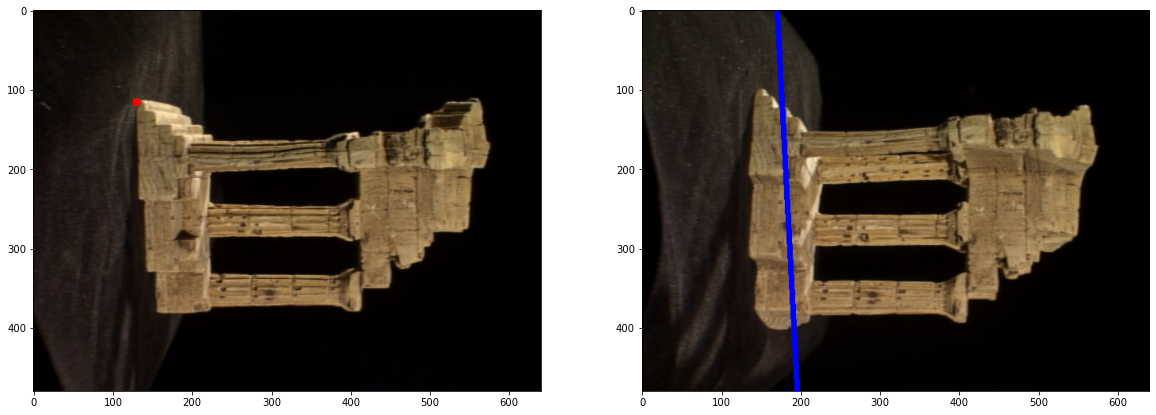

In [18]:
def skew(x):
    x = x.ravel()
    return np.array([[0,x[2],x[1]],[x[2],0,-x[0]],[-x[1],x[0],0]])
c = null_space(P1)
c = c*np.sign(c[0,0])
e2 = P2 @ c
e2x = skew(e2)
F = e2x @ P2 @ np.linalg.pinv(P1)
print('F = ', F)

x = np.array([130,115,1])
cv.circle(im1,(x[0],x[1]),5,(0,0,255),-1)

l2 = F @ x.T

p1 = np.array([0,(l2[0]*0+l2[2])/l2[1]]).astype(int)
p2 = np.array([500,(l2[0]*500+l2[2])/l2[1]]).astype(int)
cv.line(im2,(p1[0],p1[1]),(p2[0],p2[1]),(255,0,0),5)

fig,ax =plt.subplots(1,2,figsize = (20,20))
ax[0].imshow(cv.cvtColor(im1,cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(im2,cv.COLOR_BGR2RGB))

Q4

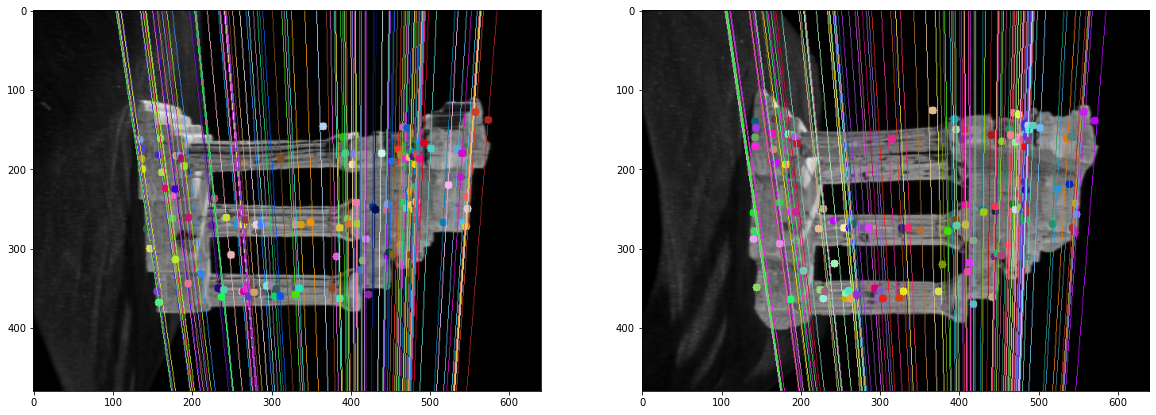

In [23]:
image1 = cv.imread(r'images/templeSparseRing/'+im1_fn,0)
image2 = cv.imread(r'images/templeSparseRing/'+im2_fn,0)

sift = cv.SIFT_create()

kp1,desc1 = sift.detectAndCompute(image1,None)
kp2,desc2 = sift.detectAndCompute(image2,None)

FLANN_INDEX_KDTREE = 1

indx_para = dict(algorithm = FLANN_INDEX_KDTREE,trees = 5)
search_para = dict(checks = 50)

flann = cv.FlannBasedMatcher(indx_para,search_para)
matches = flann.knnMatch(desc1,desc2,k=2)

points1,points2 = [], []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        points2.append(kp2[m.trainIdx].pt)
        points1.append(kp1[m.queryIdx].pt)

points1 = np.int32(points1)
points2 = np.int32(points2)

F ,mask = cv.findFundamentalMat(points1,points2,cv.FM_LMEDS)

points1 = points1[mask.ravel() == 1]
points2 = points2[mask.ravel() == 1]

def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int,[0,-r[2]/r[1]])
        x1,y1 = map(int,[c,-(r[2]+r[0]*c)/r[1]])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

lins1 = cv.computeCorrespondEpilines(points2.reshape(-1,1,2),2,F)
lins1 = lins1.reshape(-1,3)
image3,image4 = drawlines(image1,image2,lins1,points1,points2)

lins2 = cv.computeCorrespondEpilines(points2.reshape(-1,1,2),2,F)
lins2 = lins2.reshape(-1,3)
image5,image6 = drawlines(image2,image1,lins2,points2,points1)

plt.figure(figsize=(20,20))
plt.subplot(121),plt.imshow(image3)
plt.subplot(122),plt.imshow(image5)
plt.show()